In [1]:
import datasets
from tqdm import tqdm

train_data = datasets.load_dataset("allenai/pixmo-count", split="train")
count_range = range(0, 10)

/home/simone/miniconda3/envs/counting/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


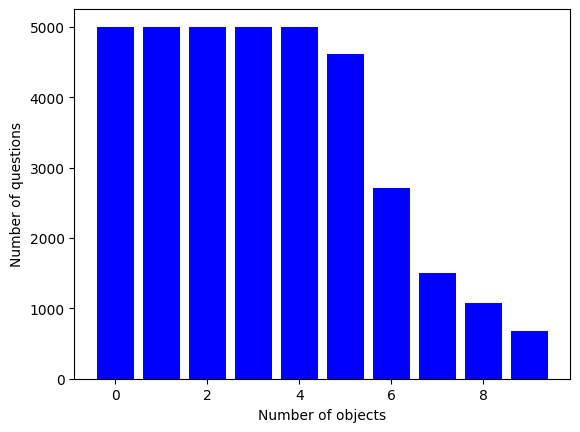

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

n_images_per_class = Counter(train_data['count'])

for i in count_range:
    #print(f"Number of images with {i} objects: {n_images_per_class[i]}")
    plt.bar(i, n_images_per_class[i], label=f"{i} objects", color='blue')

plt.xlabel("Number of objects")
plt.ylabel("Number of questions")
plt.show()

In [4]:
total_questions = sum(n_images for count, n_images in n_images_per_class.items() if count in count_range)
total_questions

35547

In [5]:
min_count = min(n_images for count, n_images in n_images_per_class.items() if count in count_range)
min_count

672

In [6]:
categories_per_count = {}

for row in tqdm(train_data):
    count = row['count']
    if count not in count_range:
        continue
    if count not in categories_per_count:
        categories_per_count[count] = set()
    categories_per_count[count].update([row['label']])

100%|██████████| 36916/36916 [00:01<00:00, 21080.54it/s]


Unique categories: 365


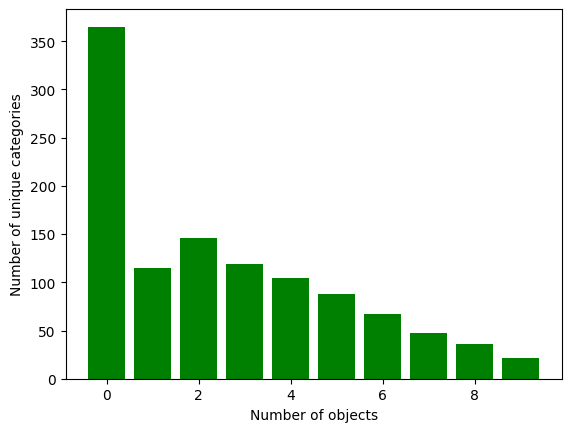

In [ ]:
unique_categories = {c for cats in categories_per_count.values() for c in cats}
print(f"Unique categories: {len(unique_categories)}")
n_categories_per_count = {i: len(categories_per_count[i]) for i in count_range}
plt.bar(n_categories_per_count.keys(), n_categories_per_count.values(), color='green') # type: ignore
plt.xlabel("Number of objects")
plt.ylabel("Number of unique categories")
plt.show()

Total categories in validation set: 51
Intersection of validation categories: 51


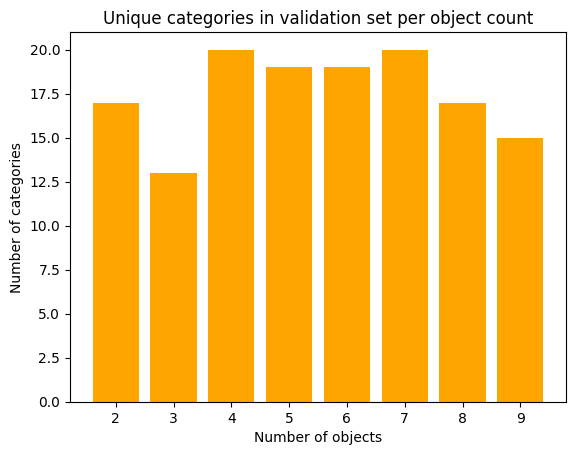

In [8]:
valid_data = datasets.load_dataset("allenai/pixmo-count", split="validation")

validation_categories = set()
validation_categories_per_count = {}
for row in valid_data:
    count = row['count'] # type: ignore
    if count in count_range:
        validation_categories.update([row['label']]) # type: ignore
        if count not in validation_categories_per_count:
            validation_categories_per_count[count] = set()
        validation_categories_per_count[count].update([row['label']]) # type: ignore

print(f"Total categories in validation set: {len(validation_categories)}")
print(f"Intersection of validation categories: {len(validation_categories.intersection(unique_categories))}")

for i in count_range:
    if i not in validation_categories_per_count:
        continue
    plt.bar(i, len(validation_categories_per_count[i]), label=f"{i} objects", color='orange')
plt.xlabel("Number of objects")
plt.ylabel("Number of categories")
plt.title("Unique categories in validation set per object count")
plt.show()

Total categories in test set: 60
Intersection of test categories: 60


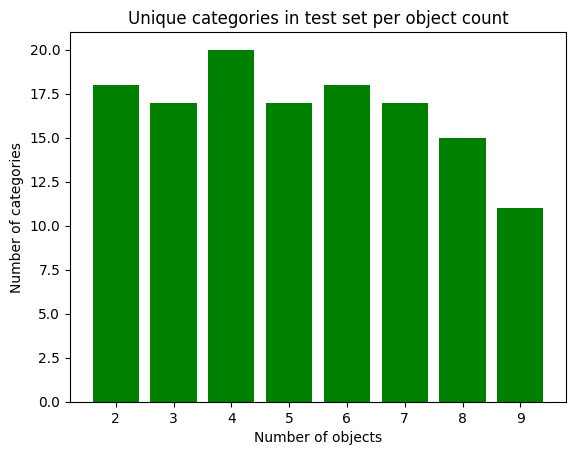

In [9]:
test_data = datasets.load_dataset("allenai/pixmo-count", split="test")

test_categories = set()
test_categories_per_count = {}
for row in test_data:
    test_categories.update([row['label']]) # type: ignore
    count = row['count'] # type: ignore
    if count in count_range:
        if count not in test_categories_per_count:
            test_categories_per_count[count] = set()
        test_categories_per_count[count].update([row['label']]) # type: ignore

print(f"Total categories in test set: {len(test_categories)}")
print(f"Intersection of test categories: {len(test_categories.intersection(unique_categories))}")

for i in count_range:
    if i not in test_categories_per_count:
        continue
    plt.bar(i, len(test_categories_per_count[i]), label=f"{i} objects", color='green')
plt.xlabel("Number of objects")
plt.ylabel("Number of categories")
plt.title("Unique categories in test set per object count")
plt.show()
    

In [10]:
print(f"Total unique categories in validation and test sets: {len(validation_categories.union(test_categories))}")

Total unique categories in validation and test sets: 76


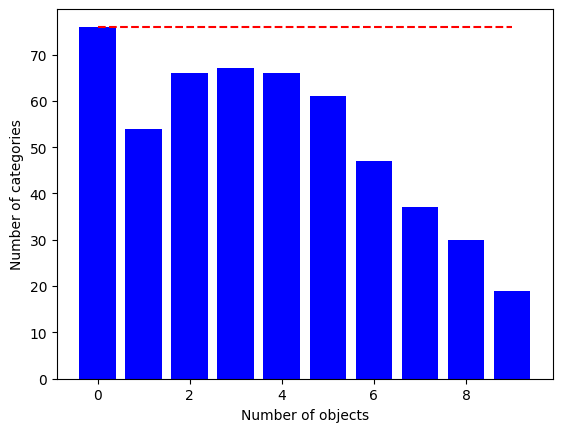

In [11]:
useful_categories = validation_categories.union(test_categories)
for count, categories in categories_per_count.items():
    n_useful_categories = categories.intersection(useful_categories)
    #print(f"Useful categories for count {count}: {len(n_useful_categories)}")
    plt.bar(count, len(n_useful_categories), color='blue')

plt.hlines(y=len(useful_categories), xmin=0, xmax=9, colors='red', linestyles='dashed')
plt.xlabel("Number of objects")
plt.ylabel("Number of categories")
plt.show()

In [12]:
unique_categories_from_2_to_9 = {c for count, cats in categories_per_count.items() for c in cats if count in range(2, 10)}

In [13]:
useful_categories - (unique_categories_from_2_to_9.intersection(useful_categories))

{'masks', 'ovens'}

In [14]:
useful_questions_for_count = {}

for row in tqdm(train_data):
    count = row['count']
    if count not in count_range:
        continue
    
    if row['label'] in useful_categories:
        if count not in useful_questions_for_count:
            useful_questions_for_count[count] = []
        useful_questions_for_count[count].append(row)

100%|██████████| 36916/36916 [00:01<00:00, 21029.90it/s]


In [15]:
for i in count_range:
    print(f"Useful questions for count {i}: {len(useful_questions_for_count.get(i, []))}")

Useful questions for count 0: 1059
Useful questions for count 1: 4693
Useful questions for count 2: 4739
Useful questions for count 3: 4845
Useful questions for count 4: 4911
Useful questions for count 5: 4560
Useful questions for count 6: 2680
Useful questions for count 7: 1484
Useful questions for count 8: 1064
Useful questions for count 9: 670


In [16]:
import random


dataset = {count: [] for count in count_range}
samples_per_class = 300

useful_categories_list = list(useful_categories)

random.seed(42)


for count in tqdm(count_range):
    useful_questions = useful_questions_for_count[count]
    useful_questions_per_category = {}

    for row in useful_questions:
        category = row['label']
        if category not in useful_questions_per_category:
            useful_questions_per_category[category] = []
        useful_questions_per_category[category].append(row)

    for cat in useful_questions_per_category:
        random.shuffle(useful_questions_per_category[cat])

    i = 0
    while len(dataset[count]) < samples_per_class:
        cat = useful_categories_list[i% len(useful_categories)]
        samples_per_cat = useful_questions_per_category.get(cat, [])
        if len(samples_per_cat) > 0:
            dataset[count].append(samples_per_cat.pop())
        i += 1

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 180.67it/s]


In [17]:
unique_categories_in_dataset = {count: set(row['label'] for row in dataset[count]) for count in count_range}
print(f"Unique categories in dataset: {len(set().union(*unique_categories_in_dataset.values()))}")

Unique categories in dataset: 76


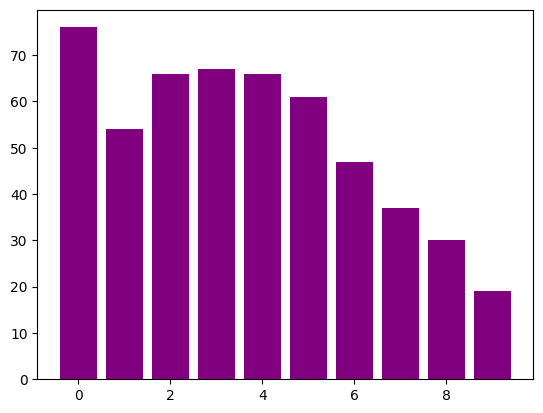

In [18]:
plt.bar(unique_categories_in_dataset.keys(), [len(unique_categories_in_dataset[count]) for count in count_range], color='purple')
plt.show()

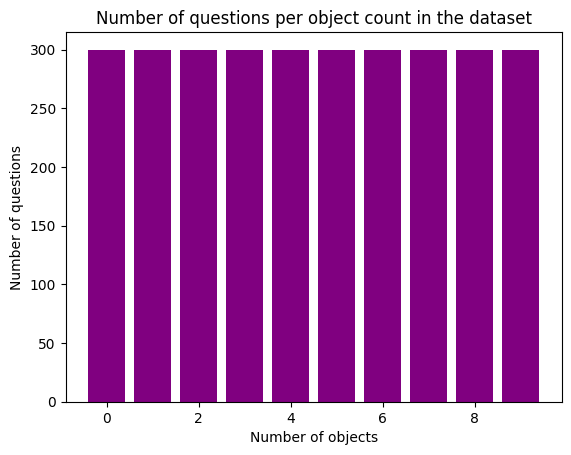

In [19]:
plt.bar(dataset.keys(), [len(dataset[count]) for count in count_range], color='purple')
plt.xlabel("Number of objects")
plt.ylabel("Number of questions")
plt.title("Number of questions per object count in the dataset")
plt.show()

In [20]:
import requests
import json
from pathlib import Path

import time

data_dir = Path('pixmo-count')

def download_image(url, save_path, max_retries=5, backoff_factor=2):
    attempt = 0
    delay = 1  # Initial delay in seconds

    while attempt < max_retries:
        try:
            response = requests.get(url, stream=True)

            if response.status_code == 429:
                print(f"Attempt {attempt + 1}: Received 429 Too Many Requests. Retrying in {delay} seconds...")
                time.sleep(delay)
                delay *= backoff_factor
                attempt += 1
                continue  # Retry the request

            response.raise_for_status()

            with open(save_path, 'wb') as out_file:
                for chunk in response.iter_content(chunk_size=8192):
                    out_file.write(chunk)

            return  # Exit after successful download

        except requests.exceptions.HTTPError as http_err:
            raise RuntimeError(f"HTTP error occurred: {http_err}") from http_err
        except requests.exceptions.RequestException as err:
            raise RuntimeError(f"Error occurred while downloading image: {err}") from err


In [ ]:

train_data_dir = data_dir / 'train'
image_train_dir = train_data_dir / 'images'
image_train_dir.mkdir(parents=True, exist_ok=True)

i = 0
samples = []
for count, rows in dataset.items():
    for row in tqdm(rows):
        try:
            download_image(row['image_url'], image_train_dir / f'{i}.jpg')
                
            row['image_path'] = f'{i}.jpg'
            samples.append(row)
            i += 1
        except RuntimeError as e:
            print(e)

with open(train_data_dir / 'samples.json', 'w') as f:
    json.dump(samples, f, indent=2)


In [23]:
with open('pixmo-count/train/samples.json', 'r') as f:
    samples = json.load(f)

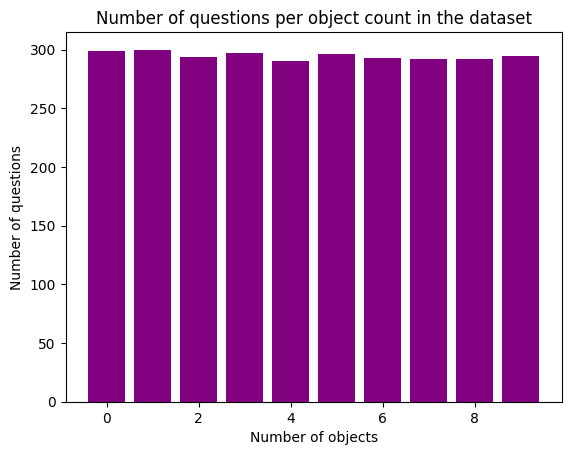

In [26]:
from collections import Counter
n_images_per_class = Counter(row['count'] for row in samples)

sorted_counts = sorted(n_images_per_class.items())
plt.bar(*zip(*sorted_counts), color='purple')
plt.xlabel("Number of objects")
plt.ylabel("Number of questions")
plt.title("Number of questions per object count in the dataset")
plt.show()

In [ ]:
valid_data_dir = data_dir / 'validation'
image_valid_dir = valid_data_dir / 'images'
image_valid_dir.mkdir(parents=True, exist_ok=True)

i = 0
valid_samples = []
for row in tqdm(valid_data):
    url = row['image_url']
    if row['count'] not in count_range:
        continue
    
    try:
        download_image(row['image_url'], image_valid_dir / f'{i}.jpg')
            
        row['image_path'] = f'{i}.jpg'
        valid_samples.append(row)
        i += 1
    except RuntimeError as e:
        print(e)

with open(valid_data_dir / 'samples.json', 'w') as f:
    json.dump(valid_samples, f, indent=2)

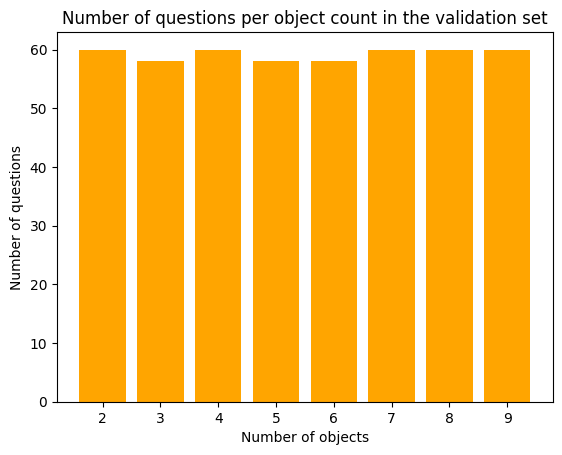

In [33]:
n_images_per_class = Counter(row['count'] for row in valid_samples)
sorted_counts = sorted(n_images_per_class.items())
plt.bar(*zip(*sorted_counts), color='orange')
plt.xlabel("Number of objects")
plt.ylabel("Number of questions")
plt.title("Number of questions per object count in the validation set")
plt.show()

In [ ]:
test_data_dir = data_dir / 'test'
image_test_dir = test_data_dir / 'images'
image_test_dir.mkdir(parents=True, exist_ok=True)

i = 0
test_samples = []
for row in tqdm(test_data):
    url = row['image_url']
    if row['count'] not in count_range:
        continue
    
    try:
        download_image(row['image_url'], image_test_dir / f'{i}.jpg')
            
        row['image_path'] = f'{i}.jpg'
        test_samples.append(row)
        i += 1
    except RuntimeError as e:
        print(e)

with open(test_data_dir / 'samples.json', 'w') as f:
    json.dump(test_samples, f, indent=2)

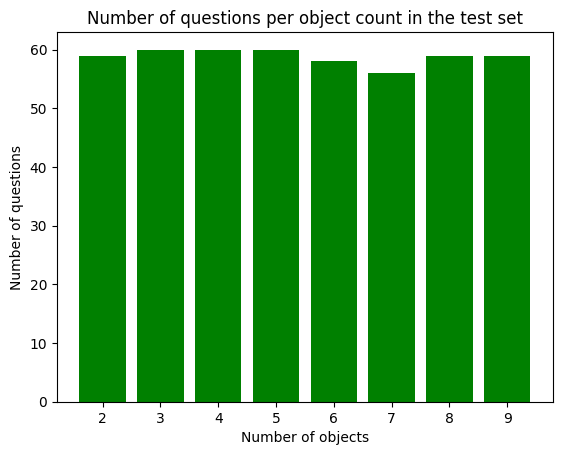

In [36]:
n_images_per_class = Counter(row['count'] for row in test_samples)
sorted_counts = sorted(n_images_per_class.items())
plt.bar(*zip(*sorted_counts), color='green')
plt.xlabel("Number of objects")
plt.ylabel("Number of questions")
plt.title("Number of questions per object count in the test set")
plt.show()